In [14]:
import pandas as pd
import random
from dataset import *

In [15]:
!pip install -q -U segmentation-models-pytorch albumentations
import segmentation_models_pytorch as smp

In [16]:
# import splitfolders
#
# splitfolders.ratio('dataset/all', output="dataset/split", seed=1337, ratio=(0.7, 0.2, 0.1))

In [17]:
DATA_DIR = os.path.join('dataset', 'split')

x_train_dir = os.path.join(DATA_DIR, 'train', 'images')
y_train_dir = os.path.join(DATA_DIR, 'train', 'masks')

x_valid_dir = os.path.join(DATA_DIR, 'val', 'images')
y_valid_dir = os.path.join(DATA_DIR, 'val', 'masks')

x_test_dir = os.path.join(DATA_DIR, 'test', 'images')
y_test_dir = os.path.join(DATA_DIR, 'test', 'masks')

In [18]:
# Get class names
class_names = ['background', 'human']
# Get class RGB values
class_rgb_values = [[0, 0, 0], [255, 255, 255]]

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_rgb_values)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  [[0, 0, 0], [255, 255, 255]]
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [19]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 30
EPOCHS2 = 10

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_PATH = os.path.join('model', 'best_model.pth')

# define losses function
loss = smp.utils.losses.CrossEntropyLoss()
loss2 = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

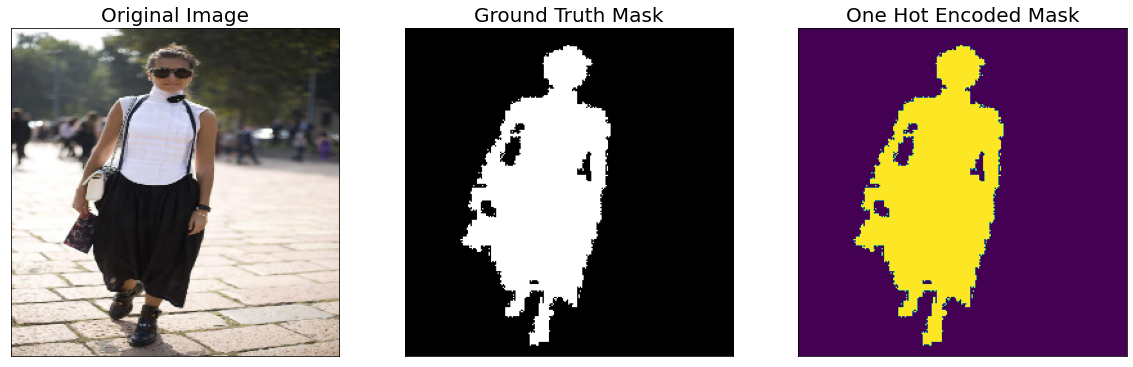

In [20]:
dataset = HumanDataset(x_train_dir, y_train_dir, class_rgb_values=class_rgb_values)

random_idx = random.randint(0, len(dataset) - 1)
image, mask = dataset[random_idx]

visualize(
    original_image=image,
    ground_truth_mask=colour_code_segmentation(reverse_one_hot(mask), class_rgb_values),
    one_hot_encoded_mask=reverse_one_hot(mask)
)

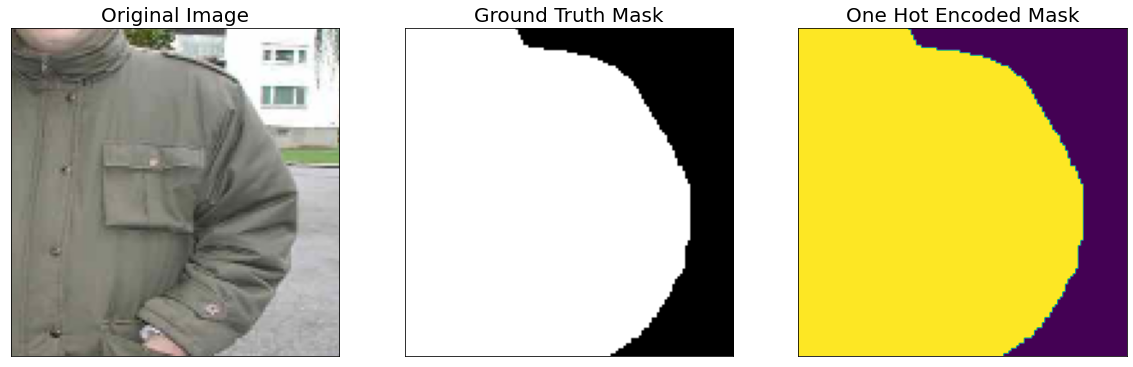

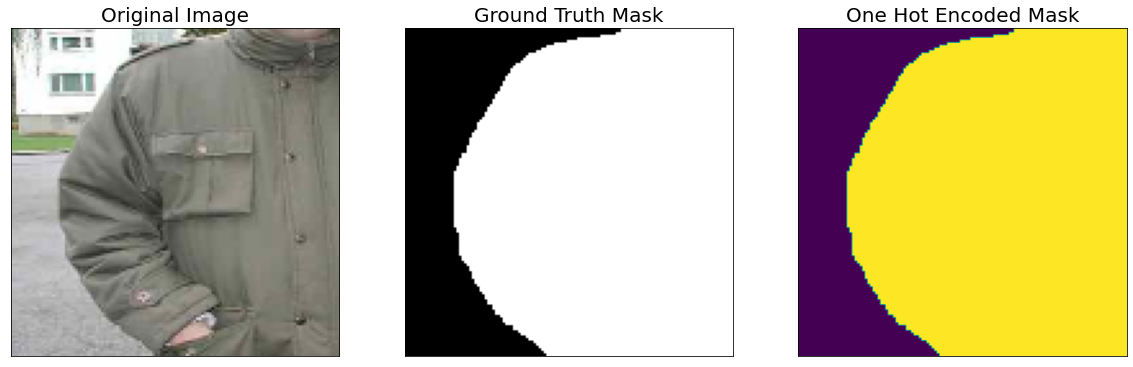

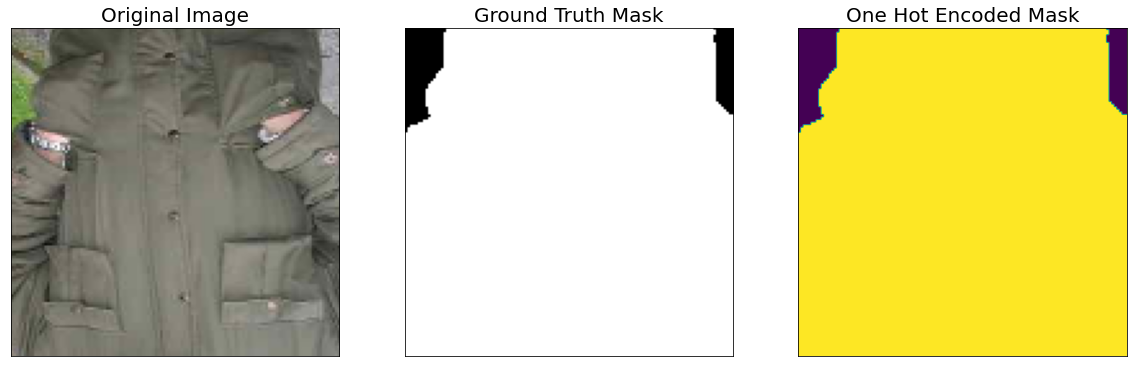

In [21]:
augmented_dataset = HumanDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    class_rgb_values=class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset) - 1)

# Different augmentations on a random image/mask pair (128*128 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image=image,
        ground_truth_mask=colour_code_segmentation(reverse_one_hot(mask), class_rgb_values),
        one_hot_encoded_mask=reverse_one_hot(mask)
    )

In [22]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid'  # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [23]:
# Get train and val dataset instances
train_dataset = HumanDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=class_rgb_values,
)

valid_dataset = HumanDataset(
    x_valid_dir, y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [24]:
# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

# load best saved model checkpoint from previous commit (if present)
if os.path.exists(MODEL_PATH):
    model = torch.load(MODEL_PATH, map_location=DEVICE)

In [25]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

train_epoch2 = smp.utils.train.TrainEpoch(
    model,
    loss=loss2,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch2 = smp.utils.train.ValidEpoch(
    model,
    loss=loss2,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [26]:
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, MODEL_PATH)
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 258/258 [00:10<00:00, 23.60it/s, cross_entropy_loss - 0.3632, iou_score - 0.891] 
Model saved!

Epoch: 1
valid: 100%|██████████| 258/258 [00:11<00:00, 23.36it/s, cross_entropy_loss - 0.3418, iou_score - 0.9122]
Model saved!

Epoch: 2
valid: 100%|██████████| 258/258 [00:11<00:00, 23.11it/s, cross_entropy_loss - 0.3373, iou_score - 0.9122]

Epoch: 3
valid: 100%|██████████| 258/258 [00:11<00:00, 23.09it/s, cross_entropy_loss - 0.3351, iou_score - 0.9159]
Model saved!

Epoch: 4
valid: 100%|██████████| 258/258 [00:11<00:00, 23.20it/s, cross_entropy_loss - 0.3276, iou_score - 0.9254]
Model saved!

Epoch: 5
valid: 100%|██████████| 258/258 [00:11<00:00, 23.19it/s, cross_entropy_loss - 0.3335, iou_score - 0.9135]

Epoch: 6
valid: 100%|██████████| 258/258 [00:11<00:00, 23.21it/s, cross_entropy_loss - 0.3309, iou_score - 0.9134]

Epoch: 7
valid: 100%|██████████| 258/258 [00:11<00:00, 23.19it/s, cross_entropy_loss - 0.3307, iou_score - 0.9156]

Epoch: 8
valid: 100

KeyboardInterrupt: 

In [27]:
if TRAINING:
    # load best saved model checkpoint from the current run
    model = torch.load(MODEL_PATH, map_location=DEVICE)
    print('Loaded best model model')

    for i in range(0, EPOCHS2):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch2.run(train_loader)
        valid_logs = valid_epoch2.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, MODEL_PATH)
            print('Model saved!')

Loaded best model model

Epoch: 0
valid: 100%|██████████| 258/258 [00:11<00:00, 22.69it/s, dice_loss - 0.054, iou_score - 0.9035]  

Epoch: 1
valid: 100%|██████████| 258/258 [00:11<00:00, 22.53it/s, dice_loss - 0.03624, iou_score - 0.934] 

Epoch: 2
valid: 100%|██████████| 258/258 [00:11<00:00, 22.60it/s, dice_loss - 0.03463, iou_score - 0.9376]

Epoch: 3
valid: 100%|██████████| 258/258 [00:11<00:00, 22.46it/s, dice_loss - 0.03515, iou_score - 0.9362]

Epoch: 4
valid: 100%|██████████| 258/258 [00:11<00:00, 21.84it/s, dice_loss - 0.03485, iou_score - 0.9365]

Epoch: 5
valid: 100%|██████████| 258/258 [00:11<00:00, 22.44it/s, dice_loss - 0.03158, iou_score - 0.942] 
Model saved!

Epoch: 6
valid: 100%|██████████| 258/258 [00:11<00:00, 21.95it/s, dice_loss - 0.03309, iou_score - 0.9394]

Epoch: 7
valid: 100%|██████████| 258/258 [00:11<00:00, 22.16it/s, dice_loss - 0.03376, iou_score - 0.9387]

Epoch: 8
valid: 100%|██████████| 258/258 [00:11<00:00, 22.21it/s, dice_loss - 0.0348, iou_score - 

In [28]:
# load best saved model checkpoint from the current run
best_model = torch.load(MODEL_PATH, map_location=DEVICE)
print('Loaded best model model')

Loaded best model model


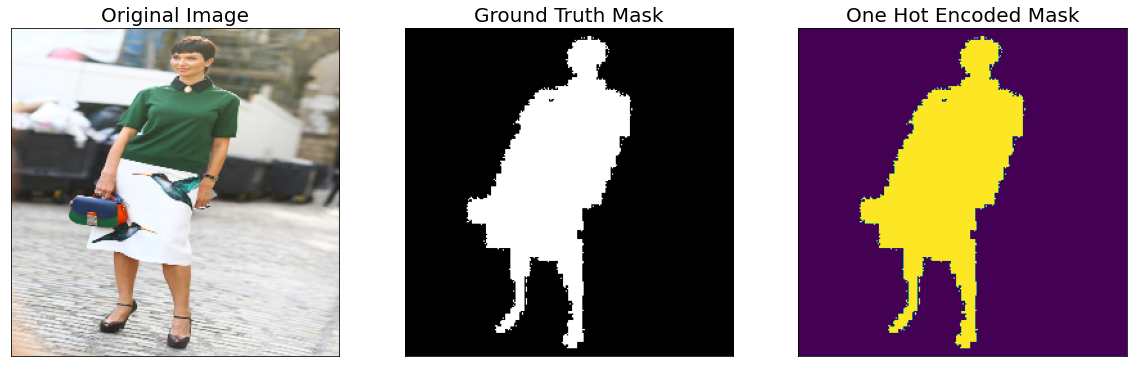

In [29]:
# create test dataloader (with preprocessing operation: to_tensor(...))
test_dataset = HumanDataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = HumanDataset(
    x_test_dir, y_test_dir,
    augmentation=get_validation_augmentation(),
    class_rgb_values=class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis) - 1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image=image,
    ground_truth_mask=colour_code_segmentation(reverse_one_hot(mask), class_rgb_values),
    one_hot_encoded_mask=reverse_one_hot(mask)
)

In [30]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

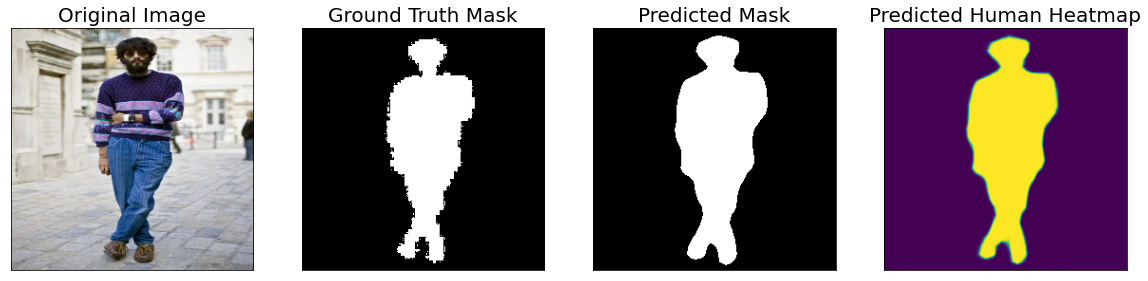

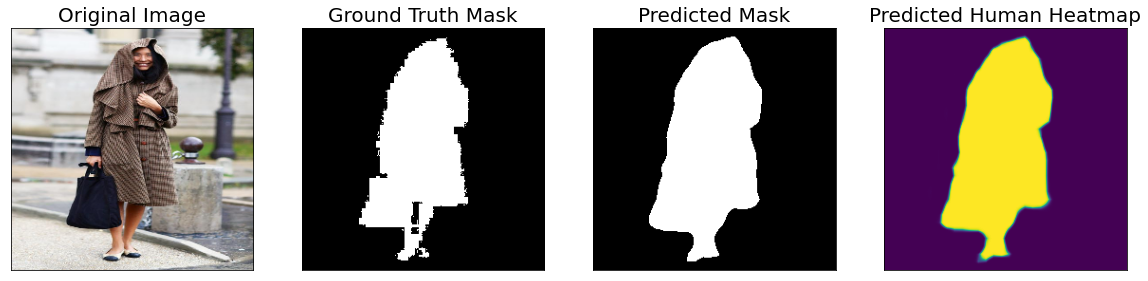

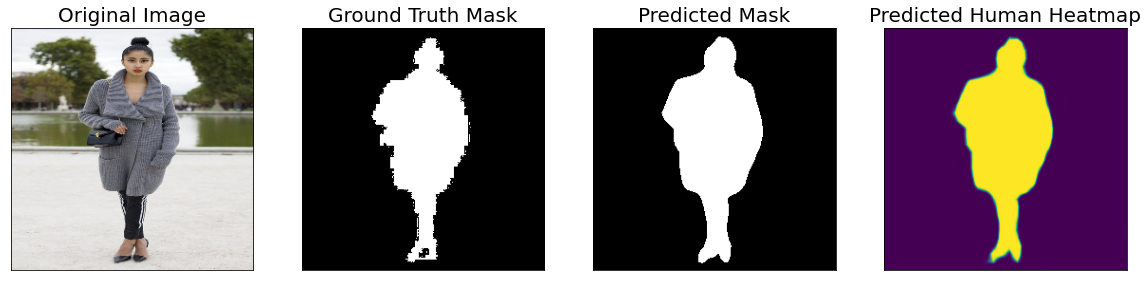

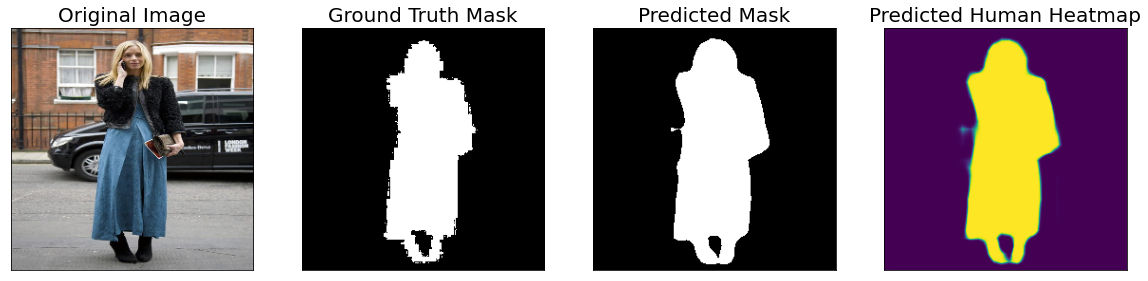

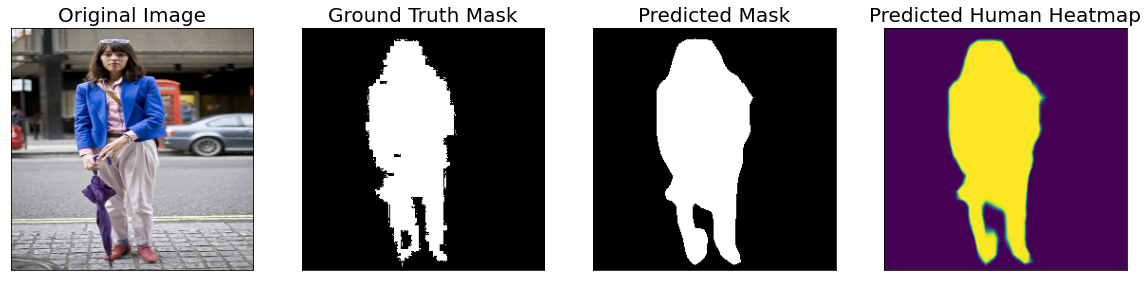

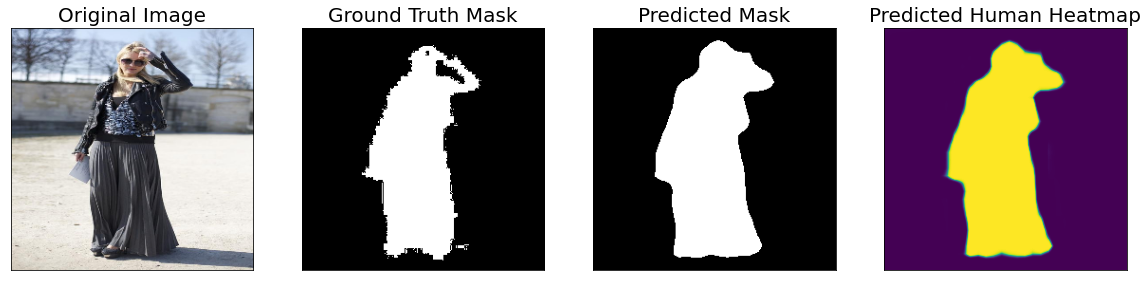

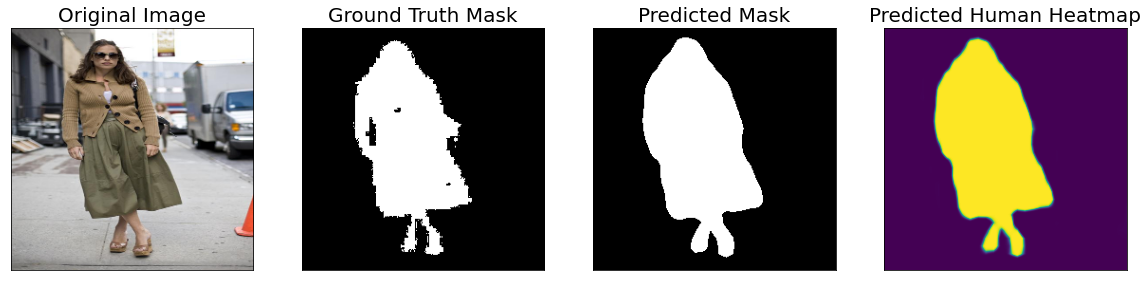

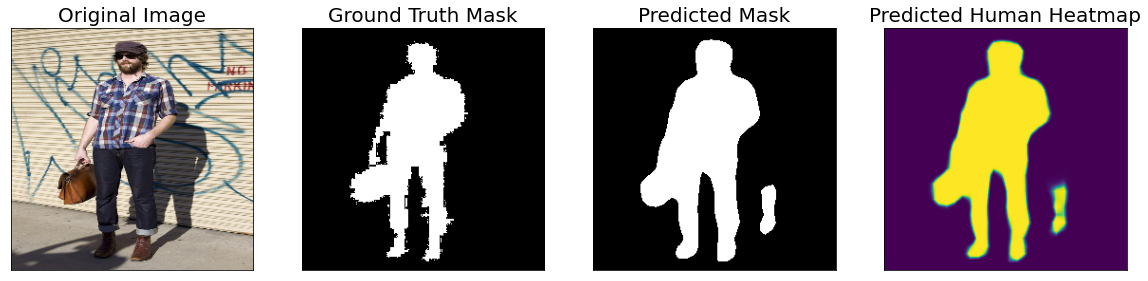

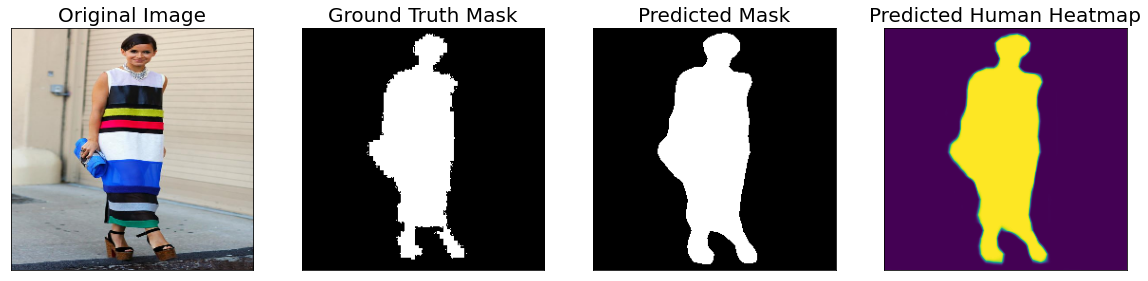

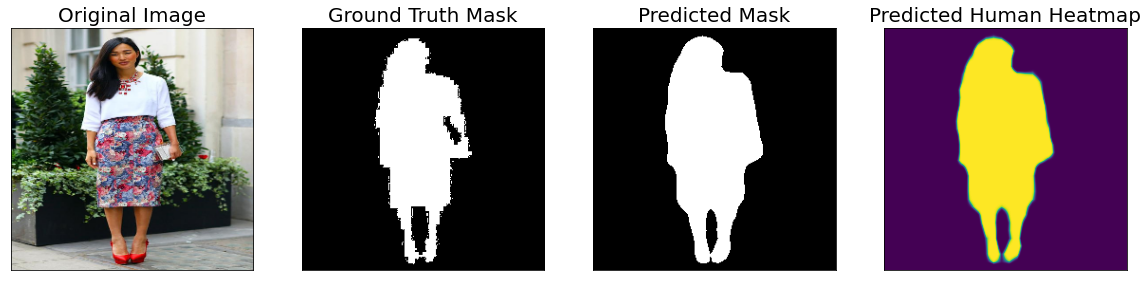

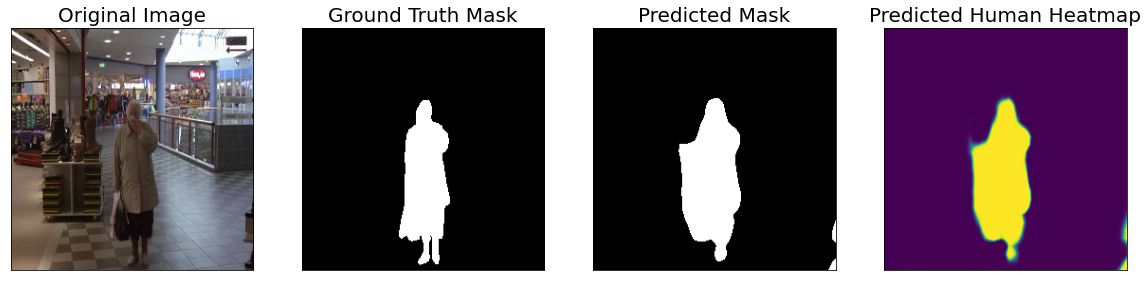

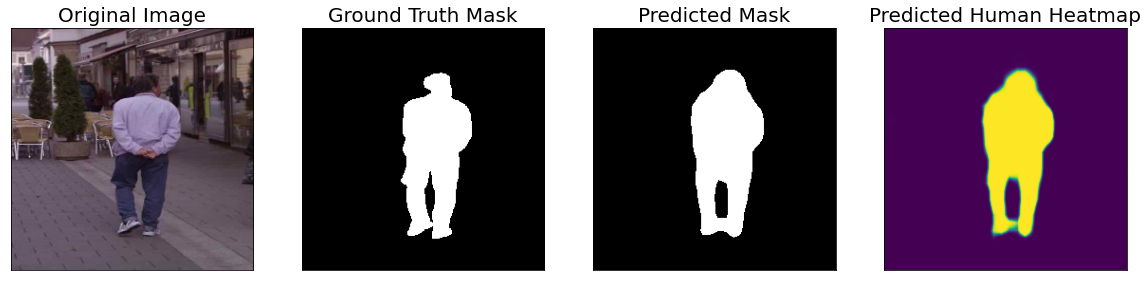

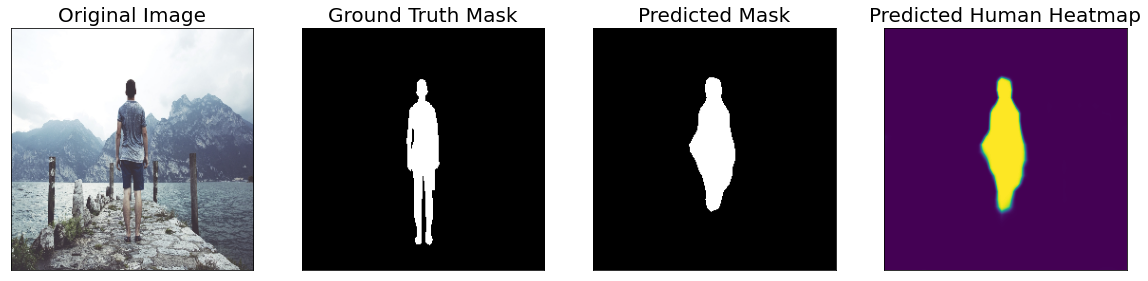

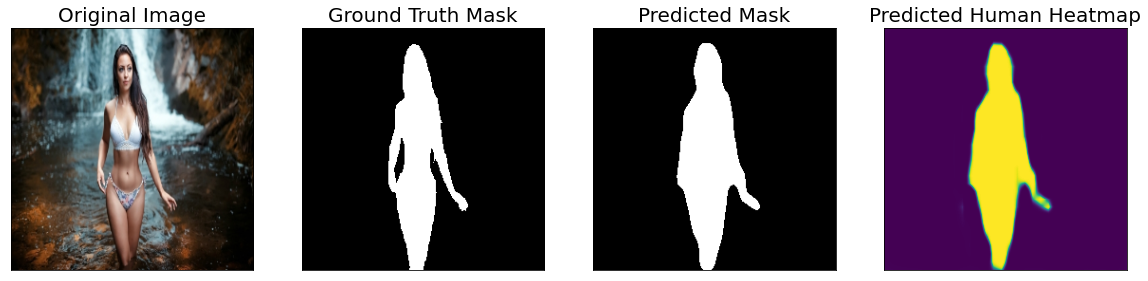

In [31]:
for idx in range(len(test_dataset)):
    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()

    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask, (1, 2, 0))

    # Get prediction channel corresponding to human
    pred_human_heatmap = pred_mask[:, :, class_names.index('human')]
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), class_rgb_values)

    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask, (1, 2, 0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), class_rgb_values)

    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"),
                np.hstack([image_vis, gt_mask, pred_mask])[:, :, ::-1])

    # visualize every 10 prediction
    if idx % 10 == 0:
        visualize(
            original_image=image_vis,
            ground_truth_mask=gt_mask,
            predicted_mask=pred_mask,
            predicted_human_heatmap=pred_human_heatmap
        )

In [33]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss2,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 131/131 [00:07<00:00, 17.53it/s, dice_loss - 0.03233, iou_score - 0.9432]
Evaluation on Test Data: 
Mean IoU Score: 0.9432
Mean Dice Loss: 0.0323


In [34]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
cross_entropy_loss,0.430290,0.370043,0.353660,0.343974,0.340020,0.337831,0.334168,0.334473,0.333674,0.330384,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iou_score,0.758735,0.843892,0.865016,0.877944,0.883586,0.884678,0.890430,0.886918,0.888446,0.894649,...,0.912814,0.918333,0.918399,0.920947,0.918736,0.910848,0.909033,0.914664,0.921620,0.914585
dice_loss,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.048822,0.045513,0.045258,0.043785,0.044898,0.049262,0.050090,0.046785,0.042884,0.046736


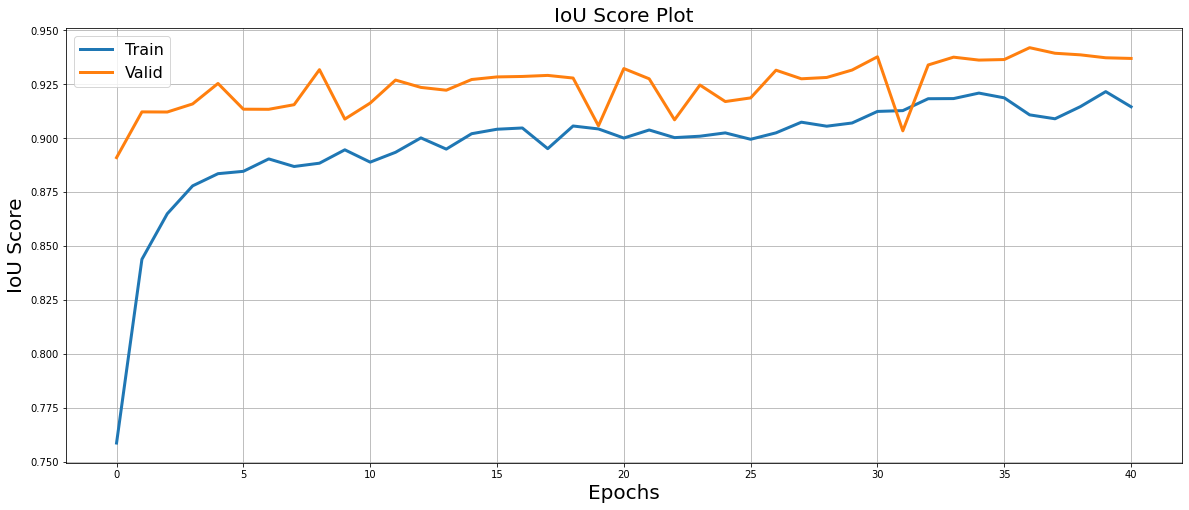

In [35]:
plt.figure(figsize=(20, 8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label='Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label='Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig(os.path.join('model', 'iou_score_plot.png'))
plt.show()

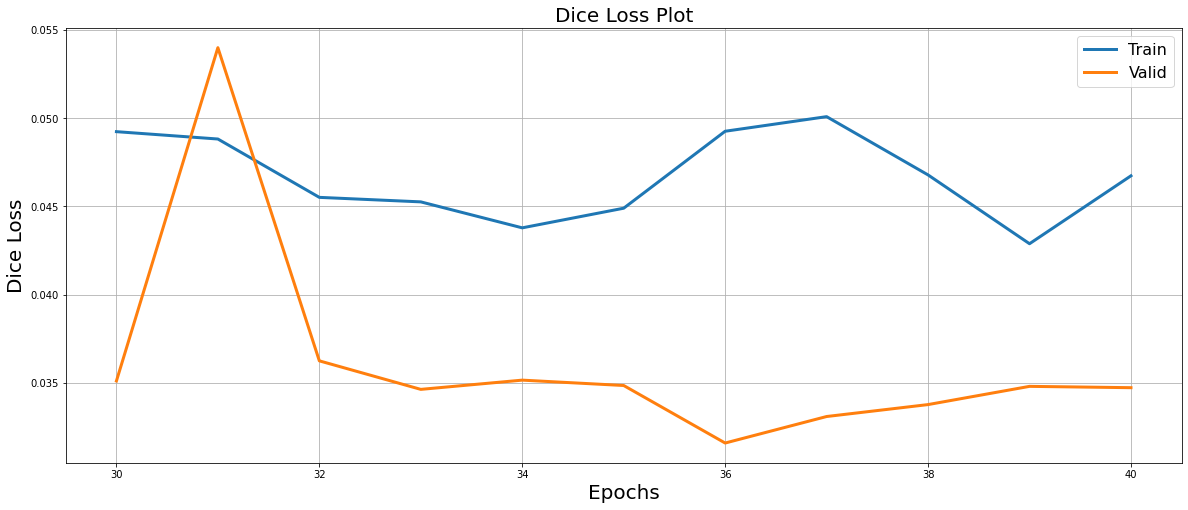

In [41]:
plt.figure(figsize=(20, 8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label='Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label='Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig(os.path.join('model', 'dice_loss_plot.png'))
plt.show()